We use all the imports we used for Lab 4, as this assignment is quite similar. We have also added some more in order make a polynomial regression model.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline

Read the data file and print with head() to give an indication that the file was read correctly.

In [2]:
location = "TSLA.csv"
df = pd.read_csv(location)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


The 'Date' column is a string, so we convert it to a datetime object. Additionally, we drop the Volume column. As we're only going to be using the 'Date' and 'Close' columns, we could have dropped all the others as well, but decided not to.

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns="Volume", inplace=True)

We create a correlation matrix. The Date appears to have a moderate to strong correlation with Close at 0.64.

In [4]:
corrMatrix = df.corr()
corrMatrix.style.background_gradient(cmap='coolwarm')

,Date,Open,High,Low,Close,Adj Close
Date,1.000000,0.761982,0.762135,0.762253,0.762298,0.762298
Open,0.761982,1.000000,0.999726,0.999618,0.999211,0.999211
High,0.762135,0.999726,1.000000,0.999627,0.999647,0.999647
Low,0.762253,0.999618,0.999627,1.000000,0.999683,0.999683
Close,0.762298,0.999211,0.999647,0.999683,1.000000,1.000000
Adj Close,0.762298,0.999211,0.999647,0.999683,1.000000,1.000000


We make a scatter plot with all the data.

<Axes: xlabel='Date', ylabel='Close'>

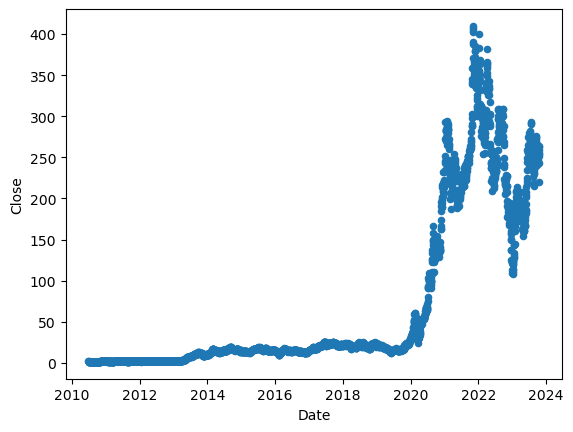

In [5]:
df.plot.scatter(x = 'Date', y = 'Close')

As can be seen here, there was a big surge in stock price during 2020. Therefore, we will focus on the dates from January 1st 2021 until October 14th 2021 (the last entry in the file). We will train the model on 2/3rds of these datapoints, and test it against the remaining one third.

<Axes: xlabel='Date', ylabel='Close'>

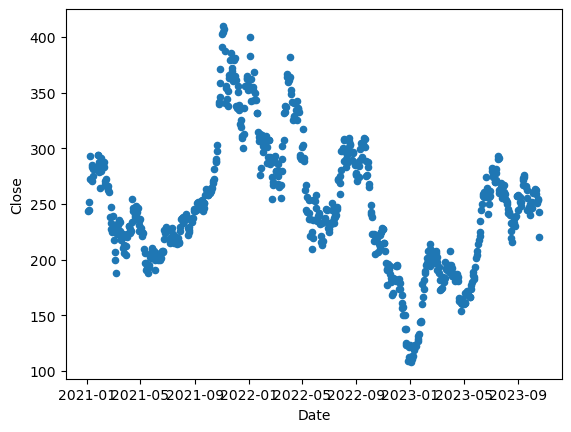

In [6]:
datetime_str = '01/01/21 00:00:00'

datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
df = df.drop(df[df.Date < datetime_object].index)
#df['Date'] = pd.to_datetime(df['Date']).astype(int)

df.plot.scatter(x = 'Date', y = 'Close')

We wanted to check how the correlation is now, when we work on only a subsection of the dataset. A value of -0.18 means there is hardly any correlation between the data.

In [7]:
corrMatrix = df.corr()
corrMatrix.style.background_gradient(cmap='coolwarm')

,Date,Open,High,Low,Close,Adj Close
Date,1.000000,-0.263440,-0.262793,-0.260752,-0.261931,-0.261931
Open,-0.263440,1.000000,0.996497,0.995024,0.989530,0.989530
High,-0.262793,0.996497,1.000000,0.995306,0.995252,0.995252
Low,-0.260752,0.995024,0.995306,1.000000,0.996001,0.996001
Close,-0.261931,0.989530,0.995252,0.996001,1.000000,1.000000
Adj Close,-0.261931,0.989530,0.995252,0.996001,1.000000,1.000000


We first define which two columns we want to base the model on - Column 0 (Date) and Column 4 (Close). Then we divide the dataset in two sets: A training set containing 67% of the entries, and a testing set containing the remaining 33% of the value. As per convention, we use a random state of 42.

In [8]:
X = pd.DataFrame(df.iloc[:, 0]) #Date
y = pd.DataFrame(df.iloc[:, 4]) #Close
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

First we decide what type of mathematical function we want to create our model. This was a bit of trial and error: But because the graph of our data swings up and down a lot, we went for a polynomial function with a very high degree (10). With some help from stackoverflow we found the right calls to train the model, and then we used chatGPT to make a graph that looked good with relevant lables.

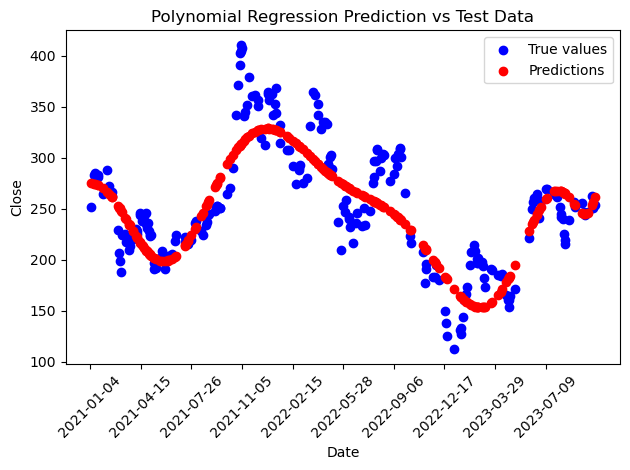

MPE = 0.10416093557339395
MSE = 1030.1681222791465


In [9]:
degree = 10
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(X_test['Date'], y_test, color='blue', label='True values')
plt.scatter(X_test['Date'], y_pred, color='red', label='Predictions')
plt.legend()

x_ticks = np.arange(min(X['Date']), max(X['Date']), (max(X['Date'])-min(X['Date']))//10)
plt.xticks(x_ticks, rotation=45)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Polynomial Regression Prediction vs Test Data')
plt.tight_layout()
plt.show()
print("MPE = "+str(100*metrics.mean_absolute_percentage_error(y_test,y_pred)))
print( "MSE = "+str(metrics.mean_squared_error(y_test,y_pred)))

The mean (absolute) percentage error here is 10%. Not too bad!

We can see how well our model would fit if we use all the data from the dataset, not just the part after the big price increase in 2020.

We do this by simply re-loading the dataset, and performing all the same steps as above, except for removing most of the entries.

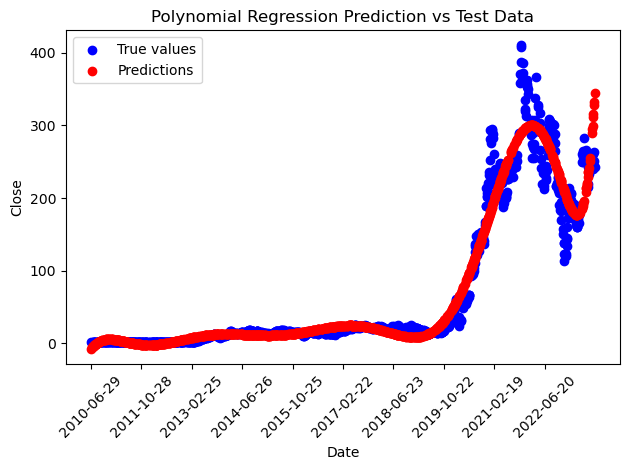

MPE = 0.5186790877917872
MSE = 494.13955074230705


In [10]:
df = pd.read_csv(location)
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns="Volume", inplace=True)
X = pd.DataFrame(df.iloc[:, 0]) #Date
y = pd.DataFrame(df.iloc[:, 4]) #Close
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
degree = 10
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(X_test['Date'], y_test, color='blue', label='True values')
plt.scatter(X_test['Date'], y_pred, color='red', label='Predictions')
plt.legend()

x_ticks = np.arange(min(X['Date']), max(X['Date']), (max(X['Date'])-min(X['Date']))//10)
plt.xticks(x_ticks, rotation=45)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Polynomial Regression Prediction vs Test Data')
plt.tight_layout()
plt.show()
print("MPE = "+str(100*metrics.mean_absolute_percentage_error(y_test,y_pred)))
print( "MSE = "+str(metrics.mean_squared_error(y_test,y_pred)))

The prediction "line" appears to follows the data reasonably well. The mean (absolute) percentage error is much higher than in our limited dataset, at 52%. We aren't too surprised, as the sudden price spike makes it hard to fit the data to a single mathematical model.

Finally, we'll save the model to disk, and subsequently test it by reading it and making a prediction (it was unlcear if this step was required for the assignment).

In [11]:
import pickle

filename = 'tesla_stock_model.sav'
pickle.dump(model, open(filename, 'wb'))

It was a little tricky to get this last part to work. The model needs the date on the format that it was trained on, which includes both the actual date and the row number. Therefore, we fetch that row that corresponds to the model we want to make a prediction on.

In [12]:
loaded_model = pickle.load(open(filename, 'rb'))

test_date = pd.to_datetime('2021-10-01')
row_for_date = X.loc[X['Date'] == test_date]
true_value_for_date = df.loc[df['Date'] == test_date]

predicted_close_price = loaded_model.predict(row_for_date)
print("Predicted value:", predicted_close_price[0][0])
print("Actual value:", true_value_for_date['Close'].iloc[0])

Predicted value: 281.43907138828905
Actual value: 258.406677
